In [1]:
!git clone https://github.com/chaklam-silpasuwanchai/NLP.git
%cd "/content/NLP/Assignment/a2 word2vec"

Cloning into 'NLP'...
remote: Enumerating objects: 768, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 768 (delta 92), reused 152 (delta 27), pack-reused 522
Receiving objects: 100% (768/768), 235.60 MiB | 28.65 MiB/s, done.
Resolving deltas: 100% (307/307), done.
Checking out files: 100% (119/119), done.
/content/NLP/Assignment/a2 word2vec


In [3]:
import numpy as np
import random

#make sure you got these folder
from utils.gradcheck import gradcheck_naive, grad_tests_softmax, grad_tests_negsamp
from utils.utils import normalizeRows, softmax

## Assignment 2: Word2Vec

### Estimated Time: ~10 hours

**Quick note**:  This assignment may be overwhelming for some of you.  It may be wise to set aside some significant amount of time so you can slowly go over this assignment.  The objective of this assignment is for you to understand the math behind <code>word2vec</code>, which will be a good fundamental background to understand any other NLP embedding algorithms.  We will also attempt to implement those maths into code to further enhance our understandings.

Let’s have a quick refresher on the word2vec algorithm. For full details, you may want to rewatch the zoom video we did in our first two lectures.  

The key insight behind word2vec is that *a word is known by the company it keeps*. Concretely, suppose we have a **center** word $c$ and a contextual window. We shall refer to words that lie in this contextual window as **outside words** denoting $o$. For example, in Figure 1 we see that the center word $c$ is *banking*. Since the context window size is 2, the outside words are *turning*, *into*, *crises*, and *as*.

The goal of the skip-gram word2vec algorithm is to accurately learn the probability distribution $P(O|C)$. Given a specific word $o$ and a specific word $c$, we want to calculate $P (O = o|C = c)$, which is the probability that word $o$ is an *outside* word for $c$, i.e., the probability that $o$ falls within the contextual window of $c$.

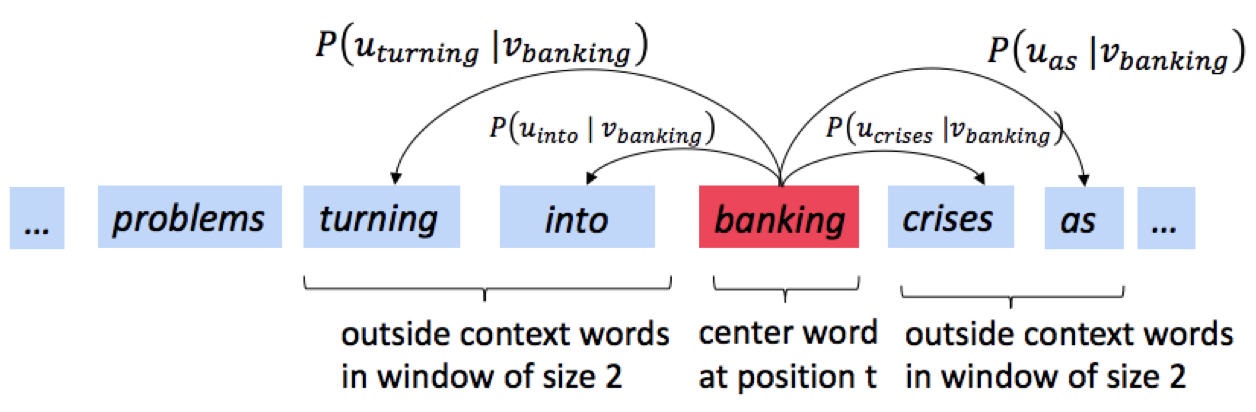

In word2vec, the conditional probability distribution is given by taking vector dot-products and applying the softmax function:

$$P (O = o|C = c) = \displaystyle\frac{\exp({\mathbf{u}_o^{T} \mathbf{v}_c})}{\sum_{w \in V} \exp({\mathbf{u}_w^{T} \mathbf{v}_c})}$$

Here, $\mathbf{u}_o$ is the *outside* vector representing outside word $o$, and $\mathbf{v}_c$ is the *center* vector representing center word $c$. To contain these parameters, we have two matrices, $\mathbf{U}$ and $\mathbf{V}$ . The columns of $\mathbf{U}$ are all the *outside* vectors $\mathbf{u}_w$. The columns of $\mathbf{V}$ are all of the *center* vectors $\mathbf{v}_w$. Both $\mathbf{U}$ and $\mathbf{V}$ contain a vector for every $w \in \text{Vocabulary}$.

Recall from lectures that, for a single pair of words $c$ and $o$, the loss is given by:

$$\mathbf{J}_\text{naive-softmax}(\mathbf{v}_c, o, \mathbf{U}) = -\log P(O=o |C=c)$$

We can view this loss as the cross-entropy2 between the true distribution $\mathbf{y}$ and the predicted distribution $\hat{\mathbf{y}}$. Here, both $\mathbf{y}$ and $\hat{\mathbf{y}}$ are vectors with length equal to the number of words in the vocabulary. 

Furthermore, the $k$th entry in these vectors indicates the conditional probability of the $k$th word being an *outside word* for the given $c$. The true empirical distribution $\mathbf{y}$ is a one-hot vector with a 1 for the true outside word $o$, and $0$ everywhere else. The predicted distribution $\hat{\mathbf{y}}$ is the probability distribution $P (O|C = c)$ given by our model in above equation.

## Part 1:  Math behind word2vec (7pts)

### Question 1 (1pt)

#### <font color="red">Answer the following questions</font> 

1. What is $\mathbf{U}$ and the shape of $\mathbf{U}$?
2. What is $\mathbf{V}$ and the shape of $\mathbf{V}$?
3. What is $\mathbf{u}_o$ and the shape of $\mathbf{u}_o$?
4. What is $\mathbf{v}_c$ and the shape of $\mathbf{v}_c$?
5. What is $\mathbf{y}$ and the shape of $\mathbf{y}$?
6. What is $\hat{\mathbf{y}}$ and the shape of $\hat{\mathbf{y}}$?
7. What is the numeric range of the softmax function P (O = o|C = c)?
8. Why use $\log$ after the softmax function?

1. What is $\mathbf{U}$ and the shape of $\mathbf{U}$?
- $\mathbf{U}$ represents the collection of **all outside word vectors**. Its shape is d X w, where d is the embedding dimension and w is the total number of uniqe words in the corpus


2. What is $\mathbf{V}$ and the shape of $\mathbf{V}$?
- $\mathbf{B}$ represents the collection of **all center word vectors.** Its shape is d X w, where d is the embedding dimension and w is the total number of uniqe words in the corpus


3. What is $\mathbf{u}_o$ and the shape of $\mathbf{u}_o$?
- $\mathbf{u}_o$ is an embedded vector representing a single outside word. The shape is 1 X d, where is the embedding dimension.


4. What is $\mathbf{v}_c$ and the shape of $\mathbf{v}_c$?
- $\mathbf{v}_c$ is an embedded vector representing a single center word. The shape is 1 X d, where is the embedding dimension.


5. What is $\mathbf{y}$ and the shape of $\mathbf{y}$?
- $\mathbf{y}$ is an one-hot vector with 1 for the true outside word o, and 0 for other places. Its shape is 1 X w, where w is the total number of uniqe words in the corpus


6. What is $\hat{\mathbf{y}}$ and the shape of $\hat{\mathbf{y}}$?
- $\hat{\mathbf{y}}$ is a predicted probability distribution of the context word o, given the central word c. Its shape is 1 X w, where w is the total number of uniqe words in the corpus



7. What is the numeric range of the softmax function P (O = o|C = c)?
- Range 0 to 1. The closer to 1, the more likelihood the outside words occur given the central word c


8. Why use $\log$ after the softmax function?
- Because the softmax function will shrink every single word into range of 0- 1, with the cumulative value at 1, using logarithm will turn a very small probability like 0.0000001 into some manageable number. With negative log liklihood, the optimization function can be achieved by penalizing exponentially on the error.

### Question 2 (1pt)

Show that the naive-softmax loss is the same as the cross-entropy loss between $\mathbf{y}$ and $\hat{\mathbf{y}}$; i.e., show that

$$-\sum_{w \in V}\mathbf{y}_w \log(\hat{\mathbf{y}}_w) = -\log(\hat{\mathbf{y}}_o)$$

#### <font color="red">Write your answer here.</font> 
$$-\sum_i p_i log(q_i)$$

Above shows the cross entropy loss.
Where 
$p_i$: the real probability distribution and $q_i$: the predicted probability distribution. And because of the one-hot vector of the true value, the remaining dimensions, represented with 0, will result in 0 after dot product.

### Question 3 (1pt)

Compute the partial derivative of $\mathbf{J}_{\text{naive-softmax}}$ with respect to $\mathbf{v}_c$.

#### <font color="red">Write your answer here.</font> 
$$\frac{\partial \mathbf{J}_{\text{naive-softmax}}}{ \partial \mathbf{v}_c } = u_o - \sum_{w \in V} p(u_x | v_c) u_x$$

$$= U(\hat {\boldsymbol y} - \boldsymbol y)$$



### Question 4 (1pt)

Compute the partial derivative of $\mathbf{J}_{\text{naive-softmax}}$ with respect to each of the outside word vectors $\mathbf{u}_w$'s.  There will be two cases:  when $w = o$ , the true outside word vector, and $w \neq o$ for all other words.

#### <font color="red">Write your answer here.</font> 

$$\dfrac {\partial \boldsymbol J}{\partial \boldsymbol u_w} = 
\begin {cases}
(\hat y_w - 1)\boldsymbol v_c, &w = o \\
\hat y_w \boldsymbol v_c, &w \neq o
\end {cases}$$

### Question 5 (1pt)

Compute the derivatives of the sigmoid function given by 

$$ g(x) = \frac{1}{1+e^{-x}} $$

#### <font color="red">Write your answer here.</font> 


$$ \frac{\partial g(x)}{\partial x}
= \left( 1 - g(x) \right) g(x)$$

### Question 6 (1pt)

Now we shall consider the Negative Sampling loss, which is an alternative to the Naive Softmax loss. Assume that $K$ negative samples (words) are drawn from the vocabulary. For simplicity of notation we shall refer to them as $w_1,w_2,\cdots,w_K$ and their outside vectors as $u_1,\cdots,\mathbf{u}_k$ For this question, assume that the $K$ negative samples are distinct. In other words, $i \neq j$ implies $w_i \neq w_j$ for $i,j \in \{1,\cdots,K\}$. Note that $o \notin \{w_1,\cdots,w_K\}$. For a center word $c$ and an outside word $o$, the negative sampling loss function is given by:

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c, o, \mathbf{U}) = -\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c)) - \sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

Compute the partial derivatives of $\mathbf{J}_{\text{neg-sample}}$ with respect of $\mathbf{v}_c, \mathbf{u}_o, \text{ and } \mathbf{u}_k$.  Please write your answers in terms of the vectors $\mathbf{u}_o, \mathbf{v}_c, \text{and } \mathbf{u}_k$.  

After this, explain with one sentence why this loss function is much more efficient to compute than the naive-softmax loss.

#### <font color="red">Write your answer here.</font> 

$$\begin {aligned}
\dfrac {\partial J_{\text {neg-sample}}}{\partial \boldsymbol v_c} &= -\dfrac {\sigma(\boldsymbol u_o^T \boldsymbol v_c)(1-\sigma(\boldsymbol u_o^T \boldsymbol v_c))\boldsymbol u_o}{\sigma (\boldsymbol u_o^T \boldsymbol v_c)} -\sum_{k=1}^K \dfrac {\sigma (-\boldsymbol u_k^T \boldsymbol v_c)(1 - \sigma (-\boldsymbol u_k^T \boldsymbol v_c))(-1)\boldsymbol u_k}{\sigma (-\boldsymbol u_k^T \boldsymbol v_c)} \\
&=(\sigma(\boldsymbol u_o^T \boldsymbol v_c)-1)\boldsymbol u_o + \sum_{k=1}^K(1-\sigma(-\boldsymbol u_k^T \boldsymbol v_c))\boldsymbol u_k
\end {aligned}$$

$$\dfrac {\partial J_{\text {neg-sample}}}{\partial \boldsymbol u_o} = (\sigma (\boldsymbol u_o^T\boldsymbol v_c)-1)\boldsymbol v_c$$


$$\dfrac {\partial J_{\text {neg-sample}}}{\partial \boldsymbol u_k} = (1 -\sigma (-\boldsymbol u_k^T\boldsymbol v_c))\boldsymbol v_c$$

The higher training efficiency from negative-sampling loss is because it only needs to perform inner product with the relevant word vector, while the naive-softmax has ŷ in the partial derivative that calculate vc and and the inner product of all word vectors, leading to more computations.



### Question 7 (1pt)

Suppose the center word is $c = w_t$ and the context window is $[w_{t−m}, \cdots, w_{t−1}, w_t, w_{t+1}, \cdots, w_{t+m}]$, where $m$ is the context window size. Recall that for the skip-gram version of word2vec, the total loss for the context window is:

$$\mathbf{J}_{skip-gram}(\mathbf{v}_c, w_{t-m}, \cdots, w_{t+m}, \mathbf{U}) = \sum_{\substack{-m \leq j \leq m \\ j \neq 0}} \mathbf{J} (\mathbf{v}_c, w_{t+j}, \mathbf{U})$$

Here, $\mathbf{J}(\mathbf{v}_c, w_{t+j}, \mathbf{U})$ represents an arbirtary loss term for the center word $c=w_t$ and outside word $w_{t+j}$.  $\mathbf{J}(\mathbf{v}_c, w_{t+j}, \mathbf{U})$ could be $\mathbf{J}_{\text{naive-softmax}}$ or $\mathbf{J}_{\text{neg-sample}}$ depending on your implementation.

Write down three partial derivatives:

- (i) $\displaystyle\frac{\partial {\mathbf{J}_{\text{skip-gram}}} (\mathbf{v}_c, w_{t-m}, \cdots w_{t+m}, \mathbf{U})}{\partial \mathbf{U}}$
- (ii) $\displaystyle\frac{\partial {\mathbf{J}_{\text{skip-gram}}} (\mathbf{v}_c, w_{t-m}, \cdots w_{t+m}, \mathbf{U})}{\partial \mathbf{v}_c}$
- (iii) $\displaystyle\frac{\partial {\mathbf{J}_{\text{skip-gram}}} (\mathbf{v}_c, w_{t-m}, \cdots w_{t+m}, \mathbf{U})}{\partial \mathbf{v}_w} \text{ where } w \neq c$

Write your answers in terms of $\partial \mathbf{J}(\mathbf{v}_c, w_{t+j}, \mathbf{U})/\partial \mathbf{U}$ and $\partial \mathbf{J}(\mathbf{v}_c, w_{t+j}, \mathbf{U})/\partial \mathbf{v}_c$.  This is very simple - don't overthink - each solution should be one line.  We just want you to write so that you are more clear when you implement.

#### <font color="red">Write your answer here.</font> 

$$\begin {aligned}
\dfrac {\partial J_{\text {skip-gram}}}{\partial \boldsymbol U} &= \sum_{-m \leq j \leq m,j \neq0}\dfrac {\partial J(\boldsymbol v_c, w_{t+j}, \boldsymbol U)}{\partial \boldsymbol U} \\
\dfrac {\partial J_{\text {skip-gram}}}{\partial \boldsymbol v_c} &= \sum_{-m \leq j \leq m,j \neq 0}\dfrac {\partial J(\boldsymbol v_c, w_{t+j}, \boldsymbol U)}{\partial \boldsymbol v_c} \\
\dfrac {\partial J_{\text {skip-gram}}}{\partial \boldsymbol v_w} &= 0, \text {when} \ w \neq c
\end {aligned}$$

## Part 2:  Code (4pts)

Now you are done, you are ready to implement <code>word2vec</code>!  Please complete the implementation below.

### Question 1 Implement the sigmoid function (1pt)

This should be fairly easy.  Recall that sigmoid function is given by:

$$ g(x) = \frac{1}{1+e^{-x}} $$

In [4]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """

    # ------------------
    # Write your implementation here (~1 line).
    s = 1/ (1 + np.exp(-x))
    
    
    # ------------------

    return s

In [5]:
def test_sigmoid():
    """ Test sigmoid function """
    print("=== Sanity check for sigmoid ===")
    assert sigmoid(0) == 0.5
    assert np.allclose(sigmoid(np.array([0])), np.array([0.5]))
    assert np.allclose(sigmoid(np.array([1,2,3])), np.array([0.73105858, 0.88079708, 0.95257413]))
    print("Tests for sigmoid passed!")

In [6]:
test_sigmoid() #turn on when you are ready to test

=== Sanity check for sigmoid ===
Tests for sigmoid passed!


### Question 2 Implement the gradient computation of naive softmax (1pt)

Here, this is a function that will return the loss, the gradient with respect to $\mathbf{v}_c$ and to $\mathbf{U}$.

1. For **loss**, recall that the loss is given by 

$$\mathbf{J}_\text{naive-softmax}(\mathbf{v}_c, o, \mathbf{U}) = -\log P(O=o |C=c)$$

where 

$$P (O = o|C = c) = \displaystyle\frac{\exp({\mathbf{u}_o^{T} \mathbf{v}_c})}{\sum_{w \in V} \exp({\mathbf{u}_w^{T} \mathbf{v}_c})}$$

*Implementation consideration* - use dot product to avoid unnecessary <code>for</code> loop, i.e., <code>yhat = softmax (outsideVectors @ centerWordVec)</code> should give you the dot product of all outside word vectors with the particular center word vector.  To calculate the loss for a specific $\mathbf{u}_o$, simply put the <code>outsideWordIdx</code> as index after the softmax function.   For the softmax function, we have provided so please use it. Last, make sure that the loss is simply a scalar, i.e., shape of (1, ).

2. For **gradient with respect to $\mathbf{v}_c$**, the gradient that you have calculated should be something like this:

$$\partial \frac{J_{\text{naive_softmax}}}{\partial \mathbf{v}_c} = -\mathbf{u}_o + \sum_{x \in V} \hat{\mathbf{y}}_x \mathbf{u}_x$$

*Implementation consideration* - since the shape of $\mathbf{v}_c$ is <code>(embedding_dim, )</code>, its gradient will also have the same shape.  For people who are struggling, it should look something like this <code>-trueOutsideVec + np.sum(outsideVectors * y_hat, axis=0)</code> where <code>trueOutsideVec</code> is simply <code>outsideVectors[outsideWordIdx]</code>

3. For **gradient with respect to $\mathbf{U}$**, the gradient for true outside vector that you have calculated should be something like this:

$$\partial \frac{J_{\text{naive_softmax}}}{\partial \mathbf{u}_{w=o}} = -(\mathbf{v}_c) + \hat{\mathbf{y}}_o \cdot \mathbf{v}_c$$

For not true outside vector, it is quite similar

$$\mathbf{v}_c \cdot \hat{\mathbf{y}}_{w \neq o}$$

*Implementation consideration* - note that the equation above is simply for one outside word, anyhow, as long as you use dot product, it will handle everything for you, i.e., <code>gradOutsideVecs = np.dot(y_hat, centerWordVec[:, np.newaxis].T)</code> should give you the gradient for all words except the true outside word vector.  By further subtracting it like this <code>gradOutsideVecs[outsideWordIdx] -= centerWordVec</code>, you will obtain the gradient for the true outside word vector.  Similarly above, since the shape of $\mathbf{U}$ is <code>(vocab_size, embedding_dim)</code>, its gradient will also has the same shape.

Last, you can run <code>test_naiveSoftmaxLossAndGradient()</code> to see whether your work can pass the test.  Note that gradient checking is a sanity test that only checks whether the gradient and loss values produced by your implementation are consistent with each other. Gradient check passing on its own doesn’t guarantee that you have the correct gradients. It will pass, for example, if both the loss and gradient values produced by your implementation are 0s.

In [7]:
def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implement the naive softmax loss and gradients between a center word's 
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models. For those unfamiliar with numpy notation, note 
    that a numpy ndarray with a shape of (x, ) is a one-dimensional array, which
    you can effectively treat as a vector with length x.

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    in shape (embedding_dim, )
                    (\mathbf{v}_c in our part 1)
    outsideWordIdx -- integer, the index of the outside word
                    (o of \mathbf{u}_o in our part 1)
    outsideVectors -- outside vectors is
                    in shape (vocab_size, embedding_dim) 
                    for all words in vocab (tranpose of U in our part 1)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (embedding_dim, )
                     (dJ / d\mathbf{v}_c in part 1)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (vocab_size, embedding_dim) 
                    (dJ / d\mathbf{U})
    """
    
    # ------------------
    # Write your implementation here.
    ### Please use the provided softmax function
    
    
    yhat = softmax(outsideVectors @ centerWordVec)
    loss = - np.log(yhat[outsideWordIdx]) #to calculate the loss of specific u_o


    # print(f'yhat shape: {yhat.shape}')


    y = np.zeros_like(yhat)
    y[outsideWordIdx] = 1 #to define the true word


    gradCenterVec = outsideVectors.T @ (yhat - y)
    gradOutsideVecs = (yhat - y)[:, None] * centerWordVec[ None , :]

    # ------------------

    return loss, gradCenterVec, gradOutsideVecs

In [8]:
def test_naiveSoftmaxLossAndGradient():
    """ Test naiveSoftmaxLossAndGradient """
    dataset, dummy_vectors, dummy_tokens = getDummyObjects()

    print("==== Gradient check for naiveSoftmaxLossAndGradient ====")
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = naiveSoftmaxLossAndGradient(vec, 1, dummy_vectors, dataset)
        return loss, gradCenterVec
    gradcheck_naive(temp, np.random.randn(3), "naiveSoftmaxLossAndGradient gradCenterVec")

    centerVec = np.random.randn(3)
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = naiveSoftmaxLossAndGradient(centerVec, 1, vec, dataset)
        return loss, gradOutsideVecs
    gradcheck_naive(temp, dummy_vectors, "naiveSoftmaxLossAndGradient gradOutsideVecs")

In [9]:
def getDummyObjects():
    """ Helper method for naiveSoftmaxLossAndGradient and negSamplingLossAndGradient tests """

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0,4)], \
            [tokens[random.randint(0,4)] for i in range(2*C)]

    dataset = type('dummy', (), {})()
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10,3))
    dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])

    return dataset, dummy_vectors, dummy_tokens

In [10]:
test_naiveSoftmaxLossAndGradient() #turn on when you are ready to test

==== Gradient check for naiveSoftmaxLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.


### Question 3 Implement the gradient computation using negative sampling loss (1pt)

1. For **loss**, recall that the negative sampling loss is

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c, o, \mathbf{U}) = -\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c)) - \sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

*Coding implementation*:  <code>indices</code> are given where the first index belongs to the true outside word, while the remaining $K$ number of indices belong to the negative samples.  For negative sampling, we have provided the function <code>getNegativeSamples</code> so please use it.  One good way to do this is first to calculate the dot product between all relevant outside word vectors within the selected indices and the center word vector like this <code>scores = (outsideVectors[indices] @ centerWordVec)[:, np.newaxis]</code>.  Then for the left side of the equation, use <code>scores[0]</code> as part of the calculation, and for the right side, use <code>-scores[1:]</code>.  The remaining should be easy, applying the already implemented <code>sigmoid</code> function, and <code>log</code> and <code>np.sum</code> accordingly.  Final reminder that the loss is of scalar (1, ) shape.

2. For **gradient with respect to $\mathbf{v}_c$**, the gradient that you have calculated should be something like this:

$$ \frac{\partial \mathbf{J}_{\text{neg-sample}}}{\partial \mathbf{v}_c} = \mathbf{u}_o(1 - \sigma(\mathbf{u}_o^T\mathbf{v}_c)) + \sum_{k=1}^{K} \mathbf{u}_k(1 - \sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

*Coding implementation*: for the left side of the equation, you may want to use <code>outsideVectors[outsideWordIdx]</code>, and for the right side of the equation, use <code>outsideVectors[negSampleWordIndices]</code>.  Other than that, this should be fairly simple.  Remind that the output shape is <code>(embedding_dim, )</code>

3. For **gradient with respect to $\mathbf{U}$**, there are two parts, the gradient for true outside vector that you have calculated should be something like this:

$$\frac{\partial \mathbf{J}_{\text{neg-sample}}}{\partial \mathbf{u}_o} = -\mathbf{v}_c(1 - \sigma(\mathbf{u}_o^T\mathbf{v}_c))$$

The gradient for negative vector that you have calculated should be something like this:

$$\frac{\partial \mathbf{J}_{\text{neg-sample}}}{\partial \mathbf{u}_k} = \mathbf{v}_c(1 - \sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

*Coding implementation*:  Both of the gradient should be simple to implement using the indexing approach we have done before.  There is some technicality, i.e., the same word may be negatively sampled multiple times. For example if an outside word is sampled twice, you shall have to double count the gradient with respect to this word. Thrice if it was sampled three times, and so forth.  A good way to do this is to first count the occurrences of indices like this:  <code>indexCount = np.bincount(indices)[:, np.newaxis]</code>, then loop through all distinct indices and multiply the gradients with the number of occurences like this: <code>for i in np.unique(indices): gradOutsideVecs[i] *= indexCount[i]</code>

Last, for sanity checking, run the <code>test_negSamplingLossAndGradient</code>

In [11]:
#we have provided the function for getting negative samples
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices #[K, ]

In [12]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implement the negative sampling loss and gradients for a centerWordVec
    and a outsideWordIdx word vector as a building block for word2vec
    models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. For
    example if an outside word is sampled twice, you shall have to
    double count the gradient with respect to this word. Thrice if
    it was sampled three times, and so forth.

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    # Negative sampling of words is done for you.
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices

    # ------------------
    # Write your implementation here
    
    gradCenterVec   = np.zeros(centerWordVec.shape)
    gradOutsideVecs = np.zeros(outsideVectors.shape)
    loss = 0.0

    u_o = outsideVectors[outsideWordIdx]
    z = sigmoid(np.dot(u_o,centerWordVec))
    loss -= np.log(z)
    gradCenterVec += u_o*(z-1)
    gradOutsideVecs[outsideWordIdx] = centerWordVec*(z-1)

    for i in range(K):
        neg_id = indices[i+1]
        u_k = outsideVectors[neg_id]
        z = sigmoid(-np.dot(u_k,centerWordVec))
        loss -= np.log(z)
        gradCenterVec += u_k*(1-z)
        gradOutsideVecs[neg_id] += centerWordVec*(1-z)

    
    
    # ------------------

    return loss, gradCenterVec, gradOutsideVecs

In [15]:
def test_negSamplingLossAndGradient():
    """ Test negSamplingLossAndGradient """
    dataset, dummy_vectors, dummy_tokens = getDummyObjects()

    print("==== Gradient check for negSamplingLossAndGradient ====")
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = negSamplingLossAndGradient(vec, 1, dummy_vectors, dataset)
        return loss, gradCenterVec
    gradcheck_naive(temp, np.random.randn(3), "negSamplingLossAndGradient gradCenterVec")

    centerVec = np.random.randn(3)
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = negSamplingLossAndGradient(centerVec, 1, vec, dataset)
        return loss, gradOutsideVecs
    gradcheck_naive(temp, dummy_vectors, "negSamplingLossAndGradient gradOutsideVecs")

In [16]:
test_negSamplingLossAndGradient() #turn on when you are ready to test

==== Gradient check for negSamplingLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.


### Question 4 Implement the skipgram model (1pt)

First, the string of the current center word will be send as one of the argument to the function. What you want to do is to obtain its index using the <code>word2Ind</code> function.  Also, you want to obtain the center word vector by passing the index to the <code>centerWordVectors</code>.

Second, loop through the list of <code>outsideWords</code>, in each loop, get the index using the <code>word2Ind</code> function, then pass whatever required into the function like this <code>currLoss, currGradCenter, currGradOutside = word2vecLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset)</code>, then accumulate the loss and gradients of $\mathbf{v}_c$ and $\mathbf{U}$, e.g., <code>loss += currLoss</code>.   

Last, recall Question 7 Part 1 where the gradient is 0 when $w \neq c$, thus after the for loop, we have to clear out the gradients of non-center word like this:  <code>gradCenterVecs[np.arange(gradCenterVecs.shape[0]) != currCenterWordIdx] = 0</code>

Note that <code>word2vecLossAndGradient</code> is a wrapper function that can call both <code>negSamplingLossAndGradient</code> and <code>naiveSoftmaxLossAndGradient</code>.  You do not have to do anything; it's already handle for you internallly in the test.

For sanity check, feel free to run <code>test_skipgram</code> and <code>test_word2vec</code>

In [42]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implement the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) is in shape 
                        (vocab_size, embedding_dim) 
                        for all words in vocab
    outsideVectors -- outside vectors is in shape 
                        (vocab_size, embedding_dim) 
                        for all words in vocab
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J)
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (embedding_dim, )
                     (dJ / d\mathbf{v}_c)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (vocab_size, embedding_dim) 
                    (dJ / d\mathbf{U})
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    # ------------------
    # Write your implementation here
    
    centerWordId = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[centerWordId]
    for ow in outsideWords:
        owi = word2Ind[ow]
        l, gradc,grado = word2vecLossAndGradient(centerWordVec,owi,outsideVectors,dataset)
        loss += l 
        gradCenterVecs[centerWordId] += gradc
        gradOutsideVectors += grado

      

    # ------------------
    
    return loss, gradCenterVecs, gradOutsideVectors

In [43]:
def test_skipgram():
    """ Test skip-gram with naiveSoftmaxLossAndGradient """
    dataset, dummy_vectors, dummy_tokens = getDummyObjects()

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")
    grad_tests_softmax(skipgram, dummy_tokens, dummy_vectors, dataset)

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")
    grad_tests_negsamp(skipgram, dummy_tokens, dummy_vectors, dataset, negSamplingLossAndGradient)

In [44]:
def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

In [45]:
test_skipgram()  #turn on when you are ready to test

==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.
======Skip-Gram with naiveSoftmaxLossAndGradient Test Cases======
The first test passed!
The second test passed!
The third test passed!
All 3 tests passed!
==== Gradient check for skip-gram with negSamplingLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.
======Skip-Gram with negSamplingLossAndGradient======
The first test passed!
The second test passed!
The third test passed!
All 3 tests passed!


In [59]:
def test_word2vec():
    """ Test the two word2vec implementations"""
    dataset = type('dummy', (), {})()

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0, 4)], \
            [tokens[random.randint(0, 4)] for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10, 3))
    dummy_tokens = dict([("a", 0), ("b", 1), ("c", 2), ("d", 3), ("e", 4)])

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")

    print("\n=== Results ===")
    print("Skip-Gram with naiveSoftmaxLossAndGradient")

    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                  dummy_tokens, dummy_vectors[:5, :], dummy_vectors[5:, :], dataset)
    )
    )

    print("Expected Result: Value should approximate these:")
    print("""Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]
    """)        




    print("Skip-Gram with negSamplingLossAndGradient")
    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                  dummy_tokens, dummy_vectors[:5, :], dummy_vectors[5:, :], dataset)
    )
    )
    print("Expected Result: Value should approximate these:")
    print("""Loss: 16.15119285363322
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-4.54650789 -1.85942252  0.76397441]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
 Gradient wrt Outside Vectors (dJ/dU):
 [[-0.69148188  0.31730185  2.41364029]
 [-0.22716495  0.10423969  0.79292674]
 [-0.45528438  0.20891737  1.58918512]
 [-0.31602611  0.14501561  1.10309954]
 [-0.80620296  0.36994417  2.81407799]]
    """)

In [60]:
test_word2vec()

==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.
==== Gradient check for skip-gram with negSamplingLossAndGradient ====
Gradient check passed!. Read the docstring of the `gradcheck_naive` method in utils.gradcheck.py to understand what the gradient check does.

=== Results ===
Skip-Gram with naiveSoftmaxLossAndGradient
Your Result:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]

Expected

### Let's put the code in action!

In this part, you do not have to do anything, just simply run the remaining code and see how your word2vec works out on a real dataset.  This will take around 1.5 hours (40,000 iterations) so go and take some rest.  The output will be a image of the embedding space.

In [62]:
import glob
import pickle
SAVE_PARAMS_EVERY = 5000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=10):
    """ Stochastic Gradient Descent
    Implement the stochastic gradient descent method in this function.
    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss
    Return:
    x -- the parameter value after SGD finishes
    """

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        def postprocessing(x): return x

    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        # YOUR CODE HERE

        loss, grad = f(x)
        # Take step in direction of gradient.
        x -= step * grad

        # END YOUR CODE

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x


def sanity_check():
    def quad(x): return (np.sum(x ** 2), x * 2)

    print("Running sanity checks...")
    t1 = sgd(quad, 0.5, 0.01, 1000, PRINT_EVERY=100)
    print("test 1 result:", t1)
    assert abs(t1) <= 1e-6

    t2 = sgd(quad, 0.0, 0.01, 1000, PRINT_EVERY=100)
    print("test 2 result:", t2)
    assert abs(t2) <= 1e-6

    t3 = sgd(quad, -1.5, 0.01, 1000, PRINT_EVERY=100)
    print("test 3 result:", t3)
    assert abs(t3) <= 1e-6

    print("-" * 40)
    print("ALL TESTS PASSED")
    print("-" * 40)

In [63]:
sanity_check()

Running sanity checks...
iter 100: 0.004578
iter 200: 0.004353
iter 300: 0.004136
iter 400: 0.003929
iter 500: 0.003733
iter 600: 0.003546
iter 700: 0.003369
iter 800: 0.003200
iter 900: 0.003040
iter 1000: 0.002888
test 1 result: 8.414836786079764e-10
iter 100: 0.000000
iter 200: 0.000000
iter 300: 0.000000
iter 400: 0.000000
iter 500: 0.000000
iter 600: 0.000000
iter 700: 0.000000
iter 800: 0.000000
iter 900: 0.000000
iter 1000: 0.000000
test 2 result: 0.0
iter 100: 0.041205
iter 200: 0.039181
iter 300: 0.037222
iter 400: 0.035361
iter 500: 0.033593
iter 600: 0.031913
iter 700: 0.030318
iter 800: 0.028802
iter 900: 0.027362
iter 1000: 0.025994
test 3 result: -2.524451035823933e-09
----------------------------------------
ALL TESTS PASSED
----------------------------------------


In [64]:
from utils.treebank import StanfordSentiment
import os.path as op
import time

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime=time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# Note that normalization is not called here. This is not a bug,
# normalizing during training loses the notion of length.

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

iter 10: 19.061546
iter 20: 19.114918
iter 30: 19.287617
iter 40: 19.352559
iter 50: 19.559119
iter 60: 19.717223
iter 70: 19.829304
iter 80: 19.829040
iter 90: 19.912663
iter 100: 19.847231
iter 110: 19.945194
iter 120: 20.068754
iter 130: 20.132756
iter 140: 20.246932
iter 150: 20.248652
iter 160: 20.181659
iter 170: 20.415366
iter 180: 20.523050
iter 190: 20.663462
iter 200: 20.735856
iter 210: 20.850365
iter 220: 20.768547
iter 230: 20.881432
iter 240: 20.874317
iter 250: 20.913310
iter 260: 21.095210
iter 270: 21.252756
iter 280: 21.158454
iter 290: 21.122248
iter 300: 21.194580
iter 310: 21.110808
iter 320: 21.122705
iter 330: 21.156881
iter 340: 21.135975
iter 350: 21.253348
iter 360: 21.273378
iter 370: 21.261887
iter 380: 21.159479
iter 390: 21.123175
iter 400: 21.256452
iter 410: 21.222920
iter 420: 21.305461
iter 430: 21.338125
iter 440: 21.254769
iter 450: 21.099340
iter 460: 21.149976
iter 470: 21.098907
iter 480: 21.073269
iter 490: 21.109938
iter 500: 20.961747
iter 510:

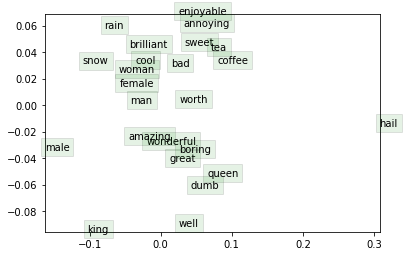

In [65]:
import matplotlib.pyplot as plt

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('word_vectors.png')